In [57]:
import numpy as np
import pandas as pd
import xgboost as xgb
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
import warnings
from copy import deepcopy
import matplotlib.pyplot as plt
from xgboost import plot_importance
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
sns.set_palette("cubehelix", 8)#"deep")
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from problem_creator import gen_regression_symbolic, gen_classification_symbolic
from scipy.stats import weightedtau
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
from mlxtend.evaluate import feature_importance_permutation
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## Utils

In [58]:
def create_test_data_uniform(data_points=1000, num_features=5, coeffs=None, data_params=None):
    if not data_params:
        data_params=(-1,1)
    if not coeffs:
        coeffs = [(i+1)*2 for i in range(num_features)]
    x = []
    for i in range(len(coeffs)):
        x.append(np.random.uniform(data_params[0],data_params[1],data_points))
    x = np.array(x).T
    fi = deepcopy(x)
   # print(coeffs)
    for i in range(len(coeffs)):
        fi[:,i] = fi[:,i]*coeffs[i]
    y = fi.sum(1)
    return x, y, fi

def create_test_data_normal(data_points=1000, num_features=5, coeffs=[], data_params=None):
    if not data_params:
        data_params=(0,1)
    if len(coeffs) == 0:
        coeffs = [(i+1)*2 for i in range(num_features)]
    x = []
    for i in range(len(coeffs)):
        x.append(np.random.normal(data_params[0],data_params[1],data_points))
    x = np.array(x).T
    fi = deepcopy(x)
    for i in range(len(coeffs)):
        fi[:,i] = fi[:,i]*coeffs[i]
    y = fi.sum(1)
    return x, y, fi

In [59]:
def simple_test_data_1(datapoints=1000, interaction_coeff=0.5):
    x1 = np.random.normal(0,1,datapoints)
    x2 = np.random.normal(0,1,datapoints)
    x3 = interaction_coeff*x1*x2
    y = 0.5*x1-x2+x3
    X = np.array([x1,x2]).T
    return X,y

## Create some data

In [60]:
x, y, fi = create_test_data_normal()
x = pd.DataFrame(x)

## Train model and apply SHAP

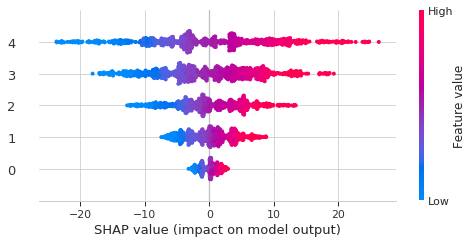

In [61]:
model = xgb.XGBRegressor(gbtree='gbtree', objective='reg:squarederror').fit(x,y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_coeffs = np.absolute(shap_values).mean(axis=0)
shap.summary_plot(shap_values, x, plot_type='dot')

### Add a correlated feature

In [62]:
x[5] = x[4] * 2
x.head()

,0,1,2,3,4,5
0,0.476506,0.985726,1.872596,-0.588224,-0.642555,-1.285110
1,0.486785,0.829661,-0.963221,0.832447,-0.261641,-0.523282
2,0.463375,-0.510217,-0.179159,0.411071,-2.222945,-4.445890
3,-0.263978,-2.192741,-1.772209,1.776845,-0.252865,-0.505730
4,0.061303,1.090313,-0.654870,-1.117093,-0.271835,-0.543669


## Train Model with correlated data and apply SHAP

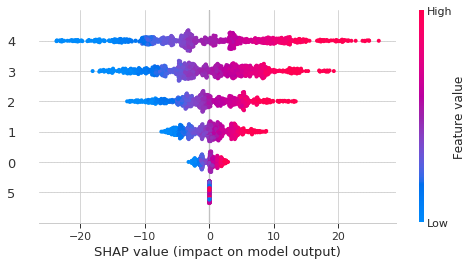

In [63]:
model = xgb.XGBRegressor(gbtree='gbtree', objective='reg:squarederror').fit(x,y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_coeffs = np.absolute(shap_values).mean(axis=0)
shap.summary_plot(shap_values, x, plot_type='dot',color='cubehelix')

### Include correlate dfeature in target creation and apply SHAP

In [21]:
def get_y(x):
    num_features = len(x.columns)
    coeffs = [(i+1)*2 for i in range(num_features)]
    print(coeffs)
    x = x.values
    fi = deepcopy(x)
    for i in range(len(coeffs)):
        fi[:,i] = fi[:,i]*coeffs[i]
    y = fi.sum(1)
    return y
y_new = get_y(x)

[2, 4, 6, 8, 10]


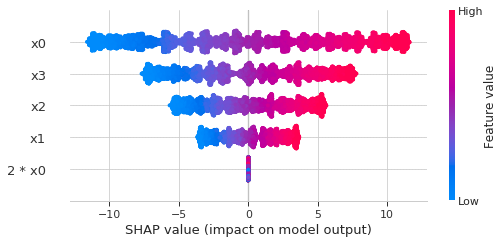

In [22]:
model = xgb.XGBRegressor(gbtree='gbtree', objective='reg:squarederror').fit(x,y_new)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_coeffs = np.absolute(shap_values).mean(axis=0)
shap.summary_plot(shap_values, x, plot_type='dot')

### Same procedure as before but with equally important features

In [51]:
poly = PolynomialFeatures(3, include_bias=False, interaction_only=False)
x = []
data_params=[-1,1]
data_points = 10000
for i in range(4):
    x.append(np.random.uniform(data_params[0],data_params[1],data_points))
x = np.array(x).T
x = pd.DataFrame(x)
x.columns = ['f{}'.format(i) for i in range(4)]
x.head()

,f0,f1,f2,f3
0,-0.601402,-0.344080,-0.794627,-0.099089
1,-0.090599,-0.577969,-0.244298,-0.002428
2,0.657372,0.525771,0.939582,-0.517103
3,-0.212531,0.140961,0.940019,-0.064173
4,-0.850564,-0.329051,-0.743954,-0.774375


In [52]:
y = poly.fit_transform(x.values).sum(axis=1)
print(poly.get_feature_names())

['x0', 'x1', 'x2', 'x3', 'x0^2', 'x0 x1', 'x0 x2', 'x0 x3', 'x1^2', 'x1 x2', 'x1 x3', 'x2^2', 'x2 x3', 'x3^2', 'x0^3', 'x0^2 x1', 'x0^2 x2', 'x0^2 x3', 'x0 x1^2', 'x0 x1 x2', 'x0 x1 x3', 'x0 x2^2', 'x0 x2 x3', 'x0 x3^2', 'x1^3', 'x1^2 x2', 'x1^2 x3', 'x1 x2^2', 'x1 x2 x3', 'x1 x3^2', 'x2^3', 'x2^2 x3', 'x2 x3^2', 'x3^3']


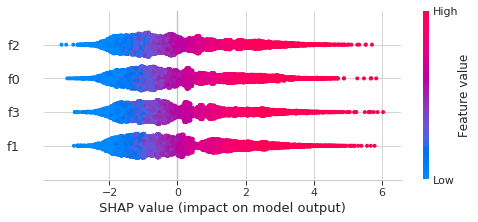

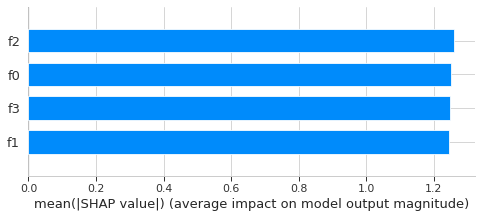

In [53]:
model = xgb.XGBRegressor(gbtree='gbtree', objective='reg:squarederror').fit(x,y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_coeffs = np.absolute(shap_values).mean(axis=0)
shap.summary_plot(shap_values, x, plot_type='dot')
shap.summary_plot(shap_values, x, plot_type='bar')
# shap_fi = np.abs(shap_values).mean(axis=0) / np.abs(shap_values).mean(axis=0).sum()
# plt.bar(np.arange(len(x.columns)),shap_fi)
# plt.title('Relative Feature Importance')
# plt.show()

In [54]:
#x['correlated_feature'] = ((x[0]+5) * 1/2) ** 3
#['correlated_feature'] = x[0]**3
#x['correlated_feature'] = x[0]  + [1]
x['2 * f0'] = x['f0']*2
x.head()

,f0,f1,f2,f3,2 * f0
0,-0.601402,-0.344080,-0.794627,-0.099089,-1.202803
1,-0.090599,-0.577969,-0.244298,-0.002428,-0.181198
2,0.657372,0.525771,0.939582,-0.517103,1.314745
3,-0.212531,0.140961,0.940019,-0.064173,-0.425062
4,-0.850564,-0.329051,-0.743954,-0.774375,-1.701129


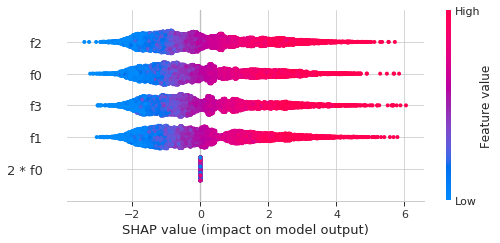

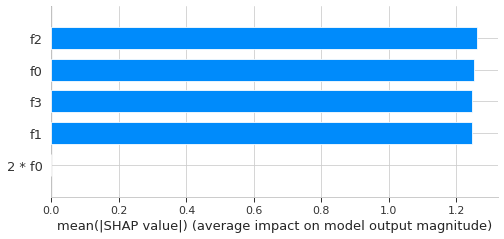

In [55]:
model = xgb.XGBRegressor(gbtree='gbtree', objective='reg:squarederror').fit(x,y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_coeffs = np.absolute(shap_values).mean(axis=0)
shap.summary_plot(shap_values, x, plot_type='dot')
shap.summary_plot(shap_values, x, plot_type='bar')
# shap_fi = np.abs(shap_values).mean(axis=0) / np.abs(shap_values).mean(axis=0).sum()
# plt.bar(np.arange(len(x.columns)),shap_fi)
# plt.title('Relative Feature Importance')
# plt.show()

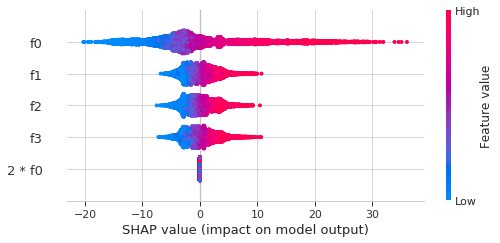

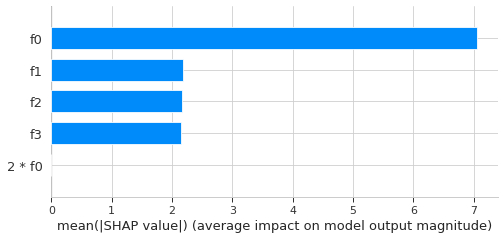

In [56]:
y = poly.fit_transform(x.values).sum(axis=1)
model = xgb.XGBRegressor(gbtree='gbtree', objective='reg:squarederror').fit(x,y)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x)
shap_coeffs = np.absolute(shap_values).mean(axis=0)
shap.summary_plot(shap_values, x, plot_type='dot')
shap.summary_plot(shap_values, x, plot_type='bar')
# shap_fi = np.abs(shap_values).mean(axis=0) / np.abs(shap_values).mean(axis=0).sum()
# plt.bar(np.arange(len(x.columns)),shap_fi)